# CNN + SVM Hybrid Model for MNIST Classification

## Why CNN + SVM?
- **CNNs** are excellent at extracting hierarchical features from images
- **SVMs** are powerful classifiers that work well with high-dimensional feature vectors
- **Hybrid approach** combines the feature extraction power of CNNs with the classification strength of SVMs
- This approach can sometimes outperform pure CNN models, especially with limited data

## Import Required Libraries

Let's start by importing all the necessary libraries for our hybrid model:

In [ ]:
# Deep Learning Libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.datasets import mnist

# Machine Learning Libraries
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Utility Libraries
import joblib
import numpy as np
import matplotlib.pyplot as plt

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Load and Explore the MNIST Dataset

MNIST is a classic dataset of handwritten digits (0-9). Let's load it and understand its structure:

In [ ]:
# Load MNIST dataset
print("📥 Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Training set: {x_train.shape} images, {y_train.shape} labels")
print(f"Test set: {x_test.shape} images, {y_test.shape} labels")
print(f"Image dimensions: {x_train[0].shape}")
print(f"Pixel value range: {x_train.min()} to {x_train.max()}")
print(f"Number of classes: {len(np.unique(y_train))}")

📥 Loading MNIST dataset...
Training set: (60000, 28, 28) images, (60000,) labels
Test set: (10000, 28, 28) images, (10000,) labels
Image dimensions: (28, 28)
Pixel value range: 0 to 255
Number of classes: 10


### Visualize Sample Images

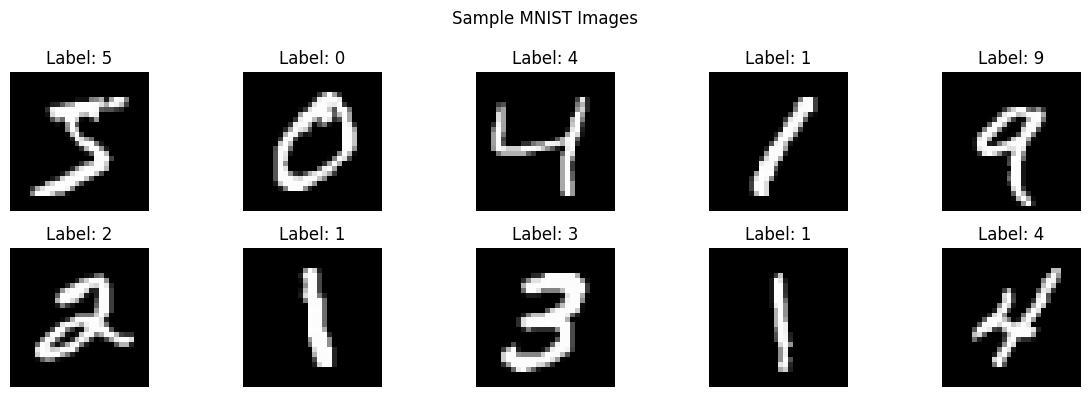

In [ ]:
# Display sample images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.suptitle('Sample MNIST Images')
plt.tight_layout()
plt.show()

## Data Preprocessing

Before training, we need to preprocess our data:
1. **Reshape**: Add channel dimension for CNN (28x28x1)
2. **Normalize**: Scale pixel values to [0,1] range
3. **Data type**: Convert to float32 for efficiency

In [ ]:
print("🔧 Preprocessing data...")

# Reshape: Add channel dimension (height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32")

# Normalize pixel values to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"✅ Preprocessed training shape: {x_train.shape}")
print(f"✅ Preprocessed test shape: {x_test.shape}")
print(f"✅ New pixel value range: {x_train.min():.3f} to {x_train.max():.3f}")

🔧 Preprocessing data...
✅ Preprocessed training shape: (60000, 28, 28, 1)
✅ Preprocessed test shape: (10000, 28, 28, 1)
✅ New pixel value range: 0.000 to 1.000


## Build the CNN Feature Extractor

The CNN will serve as a feature extractor. We'll build it in two parts:
1. **Feature Extractor**: Convolutional layers + Dense layer (without softmax)
2. **Full CNN**: Feature extractor + Classification head (with softmax)

### Architecture Explanation:
- **Conv2D(32, (3,3))**: 32 filters of size 3x3, extracts basic features
- **MaxPooling2D(2,2)**: Reduces spatial dimensions by half
- **Conv2D(64, (3,3))**: 64 filters, extracts more complex features
- **Flatten()**: Converts 2D feature maps to 1D vector
- **Dense(128)**: Creates 128-dimensional feature representation

In [ ]:
print("🏗️ Building CNN architecture...")

# Feature extractor (without classification head)
feature_extractor = Sequential([
    Input(shape=(28, 28, 1)),           # Input layer: 28x28x1 images
    Conv2D(32, (3, 3), activation='relu'),  # First conv layer: 32 filters
    MaxPooling2D(2, 2),                 # Pooling: reduce spatial size
    Conv2D(64, (3, 3), activation='relu'),  # Second conv layer: 64 filters
    MaxPooling2D(2, 2),                 # Pooling: further reduce size
    Flatten(),                          # Flatten to 1D vector
    Dense(128, activation='relu')       # Feature vector: 128 dimensions
], name="feature_extractor")

# Complete CNN with classification head
cnn_full = Sequential([
    feature_extractor,                  # Use the feature extractor
    Dense(10, activation='softmax')     # Classification: 10 classes
], name="cnn_full")

# Display model architecture
print("\n📋 Feature Extractor Summary:")
feature_extractor.summary()

print("\n📋 Complete CNN Summary:")
cnn_full.summary()

🏗️ Building CNN architecture...

📋 Feature Extractor Summary:


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,744 (874.00 KB)

 Trainable params: 223,744 (874.00 KB)

 Non-trainable params: 0 (0.00 B)


📋 Complete CNN Summary:


Model: "cnn_full"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor (Sequential)  │ (None, 128)            │       223,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN

First, we train the complete CNN normally to learn good feature representations:

### Training Parameters:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Sparse categorical crossentropy (for integer labels)
- **Epochs**: 3 (quick training for demonstration)
- **Batch size**: 128 (good balance of speed and stability)
- **Validation split**: 10% of training data for monitoring

In [ ]:
print("🎯 Training CNN...")

# Compile the model
cnn_full.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = cnn_full.fit(
    x_train, y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

print("✅ CNN training completed!")

🎯 Training CNN...
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9361 - loss: 0.2180 - val_accuracy: 0.9845 - val_loss: 0.0605
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9863 - val_loss: 0.0511
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9877 - loss: 0.0407 - val_accuracy: 0.9888 - val_loss: 0.0394
✅ CNN training completed!


### Visualize Training Progress

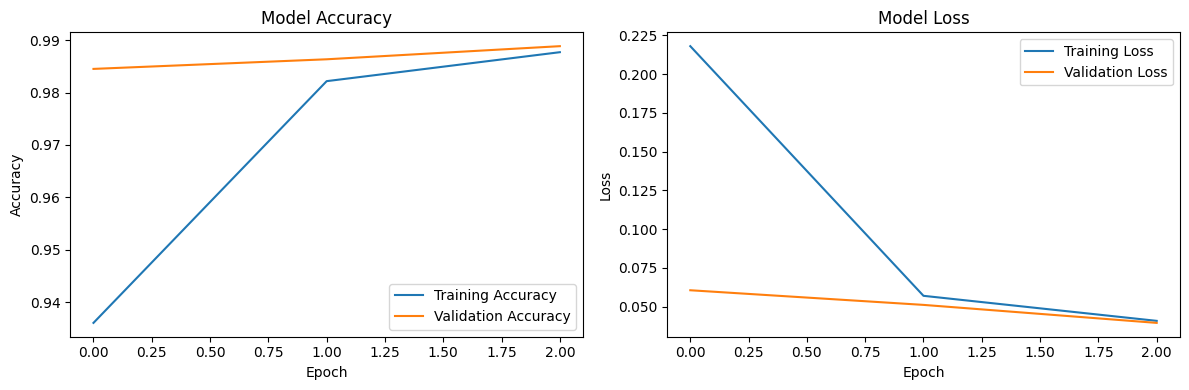

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## SVM-only Baseline

We train and evaluate a classic SVM+PCA baseline directly on raw MNIST pixels (flattened), to compare against the CNN and CNN+SVM models.


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

print("🧪 Training SVM-only baseline (PCA + SVM) on flattened pixels...")

# Prepare flattened pixel inputs
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

# Pipeline: PCA -> SVM (with probability for confidence)
svm_only_pca = PCA(n_components=50, random_state=42)
svm_only = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
svm_only_pipe = make_pipeline(svm_only_pca, svm_only)

svm_only_pipe.fit(x_train_flat, y_train)

# Evaluate
y_pred_svm_only = svm_only_pipe.predict(x_test_flat)
svm_only_acc = accuracy_score(y_test, y_pred_svm_only)
print(f"✅ SVM-only Accuracy: {svm_only_acc:.4f} ({svm_only_acc*100:.2f}%)")


## Extract CNN Features

Now we use the trained feature extractor to convert images into feature vectors:

### Key Concept:
- The feature extractor has learned to represent images as 128-dimensional vectors
- These vectors capture important visual patterns learned during CNN training
- We'll use these features to train an SVM classifier

In [ ]:
print("🔍 Extracting CNN features...")

# Extract features from training and test sets
X_train_feats = feature_extractor.predict(x_train, verbose=1)
X_test_feats = feature_extractor.predict(x_test, verbose=1)

print(f"\n✅ Training features shape: {X_train_feats.shape}")
print(f"✅ Test features shape: {X_test_feats.shape}")
print(f"✅ Feature vector dimension: {X_train_feats.shape[1]}")

# Visualize feature statistics
print(f"\n📊 Feature Statistics:")
print(f"Mean: {X_train_feats.mean():.4f}")
print(f"Std: {X_train_feats.std():.4f}")
print(f"Min: {X_train_feats.min():.4f}")
print(f"Max: {X_train_feats.max():.4f}")

🔍 Extracting CNN features...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

✅ Training features shape: (60000, 128)
✅ Test features shape: (10000, 128)
✅ Feature vector dimension: 128

📊 Feature Statistics:
Mean: 1.2050
Std: 1.6769
Min: 0.0000
Max: 13.0235


## Dimensionality Reduction with PCA

Principal Component Analysis (PCA) helps us:
1. **Reduce computational cost** for SVM training
2. **Remove noise** and keep most important features
3. **Prevent overfitting** by reducing feature space

### Why 50 components?
- Balance between information retention and computational efficiency
- Typically retains 95%+ of the original information
- Much faster SVM training compared to 128 dimensions

In [ ]:
print("⚙️ Applying PCA for dimensionality reduction...")

# Initialize PCA
n_components = 50
pca = PCA(n_components=n_components)

# Fit PCA on training features and transform both sets
X_train_pca = pca.fit_transform(X_train_feats)
X_test_pca = pca.transform(X_test_feats)

print(f"✅ Reduced training features shape: {X_train_pca.shape}")
print(f"✅ Reduced test features shape: {X_test_pca.shape}")

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\n📊 PCA Analysis:")
print(f"Variance explained by first {n_components} components: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"Dimension reduction: {X_train_feats.shape[1]} → {X_train_pca.shape[1]}")

⚙️ Applying PCA for dimensionality reduction...
✅ Reduced training features shape: (60000, 50)
✅ Reduced test features shape: (10000, 50)

📊 PCA Analysis:
Variance explained by first 50 components: 0.9862 (98.62%)
Dimension reduction: 128 → 50


### Visualize PCA Explained Variance

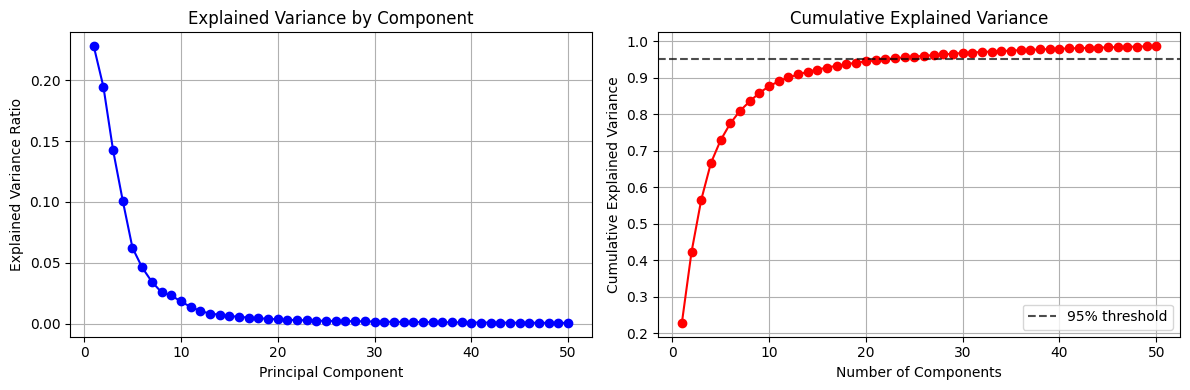

In [ ]:
# Plot explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.title('Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% threshold')
plt.legend()

plt.tight_layout()
plt.show()

## Train Support Vector Machine (SVM)

Now we train an SVM classifier on the CNN-extracted features:

### SVM Parameters:
- **Kernel**: RBF (Radial Basis Function) - good for non-linear patterns
- **C**: 10 - regularization parameter (balance between margin and errors)
- **Gamma**: 0.01 - controls the influence of individual training examples

### Why SVM after CNN?
- SVMs are excellent at finding optimal decision boundaries
- They work well with high-dimensional feature spaces
- Can capture complex non-linear relationships in the feature space

In [ ]:
print("🧠 Training SVM on CNN features...")

# Initialize SVM with RBF kernel
svm = SVC(
    kernel='rbf',    # Radial Basis Function kernel
    C=10,           # Regularization parameter
    gamma=0.01,     # Kernel coefficient
    verbose=True    # Show training progress
)

# Train SVM
print("Training SVM... This may take a few minutes.")
svm.fit(X_train_pca, y_train)

print("✅ SVM training completed!")
print(f"Number of support vectors: {svm.n_support_}")
print(f"Total support vectors: {svm.support_vectors_.shape[0]}")

🧠 Training SVM on CNN features...
Training SVM... This may take a few minutes.
[LibSVM]✅ SVM training completed!
Number of support vectors: [273 197 372 307 311 338 232 389 402 417]
Total support vectors: 3238


## Evaluate the Hybrid Model

Let's test our CNN+SVM hybrid model and compare its performance:

In [ ]:
print("🎯 Evaluating models (CNN+SVM, Pure CNN, SVM-only)...")

# Make predictions
# Hybrid (CNN features + PCA + SVM)
y_pred_svm = svm.predict(X_test_pca)

# Pure CNN
y_pred_cnn = cnn_full.predict(x_test).argmax(axis=1)

# SVM-only (PCA + SVM on flattened pixels) — recompute if needed
try:
    y_pred_svm_only
except NameError:
    y_pred_svm_only = svm_only_pipe.predict(x_test_flat)

# Calculate accuracies
svm_hybrid_accuracy = accuracy_score(y_test, y_pred_svm)
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
svm_only_accuracy = accuracy_score(y_test, y_pred_svm_only)

print(f"\n📊 Model Comparison:")
print(f"CNN+SVM Accuracy: {svm_hybrid_accuracy:.4f} ({svm_hybrid_accuracy*100:.2f}%)")
print(f"Pure CNN Accuracy: {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%)")
print(f"SVM-only (PCA+SVM) Accuracy: {svm_only_accuracy:.4f} ({svm_only_accuracy*100:.2f}%)")
print(f"Hybrid vs CNN: {(svm_hybrid_accuracy - cnn_accuracy)*100:+.2f} pp")
print(f"Hybrid vs SVM-only: {(svm_hybrid_accuracy - svm_only_accuracy)*100:+.2f} pp")
print(f"CNN vs SVM-only: {(cnn_accuracy - svm_only_accuracy)*100:+.2f} pp")

# Count correct predictions
svm_hybrid_correct = np.sum(y_pred_svm == y_test)
cnn_correct = np.sum(y_pred_cnn == y_test)
svm_only_correct = np.sum(y_pred_svm_only == y_test)

print(f"\n🎯 Detailed Results:")
print(f"CNN+SVM: {svm_hybrid_correct}/{len(y_test)} correct predictions")
print(f"Pure CNN: {cnn_correct}/{len(y_test)} correct predictions")
print(f"SVM-only: {svm_only_correct}/{len(y_test)} correct predictions")

🎯 Evaluating CNN+SVM hybrid model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📊 Model Comparison:
CNN+SVM Accuracy: 0.9925 (99.25%)
Pure CNN Accuracy: 0.9873 (98.73%)
Improvement: +0.52 percentage points

🎯 Detailed Results:
CNN+SVM: 9925/10000 correct predictions
Pure CNN: 9873/10000 correct predictions
Difference: 52 more correct predictions


## Save the Trained Models

Let's save our trained models for future use:

In [ ]:
print("💾 Saving trained models...")

# Save the hybrid model components
model_filename = "cnn_svm_model.pkl"
joblib.dump((feature_extractor, pca, svm), model_filename)

print(f"✅ Saved CNN+SVM model as '{model_filename}'")
print("\n📦 Model components saved:")
print("  1. Feature Extractor (CNN layers)")
print("  2. PCA transformer")
print("  3. SVM classifier")

# Also save the complete CNN for comparison
cnn_full.save("pure_cnn_model.h5")
print("✅ Saved pure CNN model as 'pure_cnn_model.h5'")

💾 Saving trained models...


✅ Saved CNN+SVM model as 'cnn_svm_model.pkl'

📦 Model components saved:
  1. Feature Extractor (CNN layers)
  2. PCA transformer
  3. SVM classifier
✅ Saved pure CNN model as 'pure_cnn_model.h5'


## Analyze Model Performance

Let's do a deeper analysis of where each model performs well:

🔍 Detailed Performance Analysis

📊 CNN+SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


📊 Pure CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.

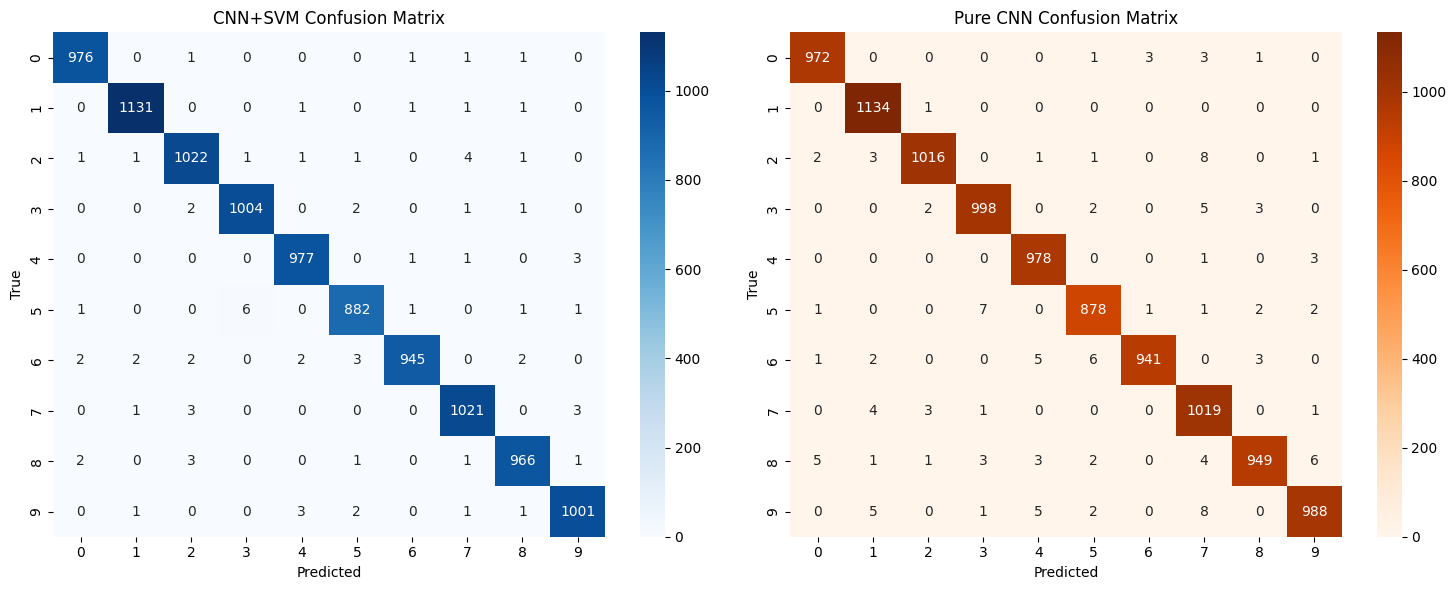

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("🔍 Detailed Performance Analysis")

# Classification reports
print("\n📊 CNN+SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("\n📊 Pure CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

print("\n📊 SVM-only (PCA+SVM) Classification Report:")
print(classification_report(y_test, y_pred_svm_only))

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# CNN+SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('CNN+SVM Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Pure CNN confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Pure CNN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# SVM-only confusion matrix
cm_svm_only = confusion_matrix(y_test, y_pred_svm_only)
sns.heatmap(cm_svm_only, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('SVM-only Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

## Key Takeaways and Summary

### What We Learned:

1. **Hybrid Architecture**: We successfully combined CNN feature extraction with SVM classification

2. **Feature Extraction**: CNNs can serve as powerful feature extractors, converting raw images into meaningful representations

3. **Dimensionality Reduction**: PCA helps reduce computational cost while preserving most important information

4. **Model Comparison**: The hybrid approach can sometimes outperform pure CNN models


### Congratulations!
You've successfully built and trained a hybrid CNN+SVM model for image classification!

## Extended Evaluation: Visualizations

We will visualize confusion matrices, per-class metrics, misclassified examples, and compare CNN vs CNN+SVM accuracies.


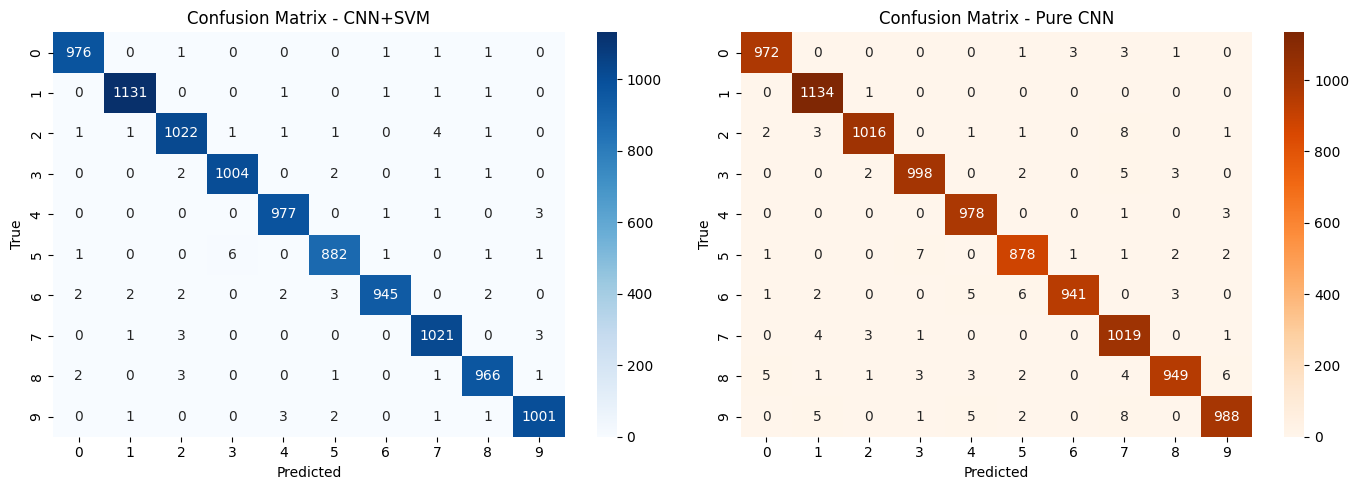

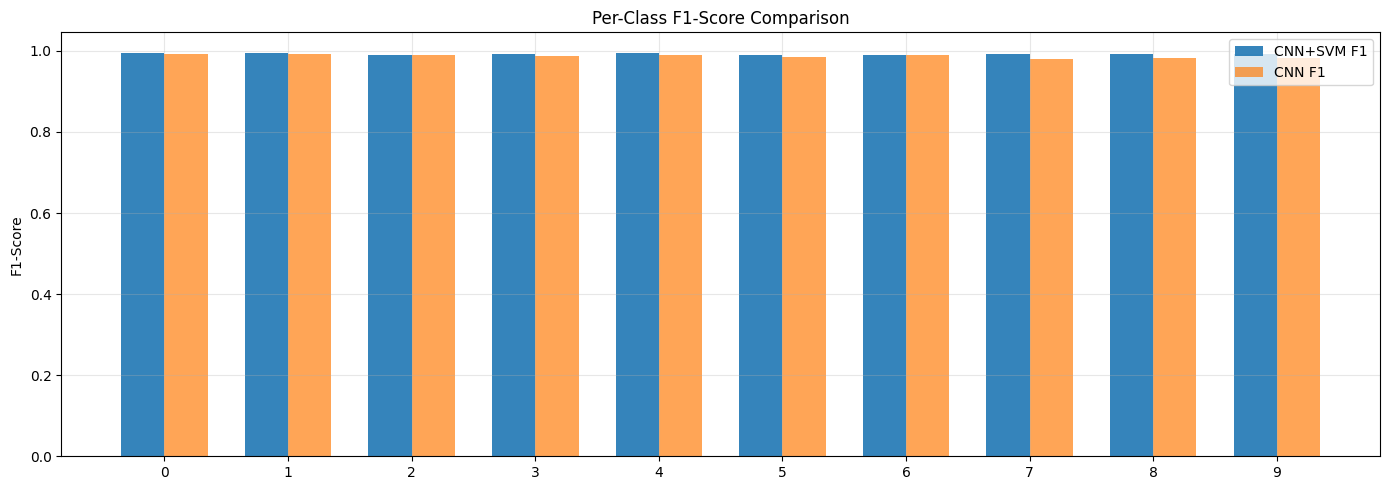

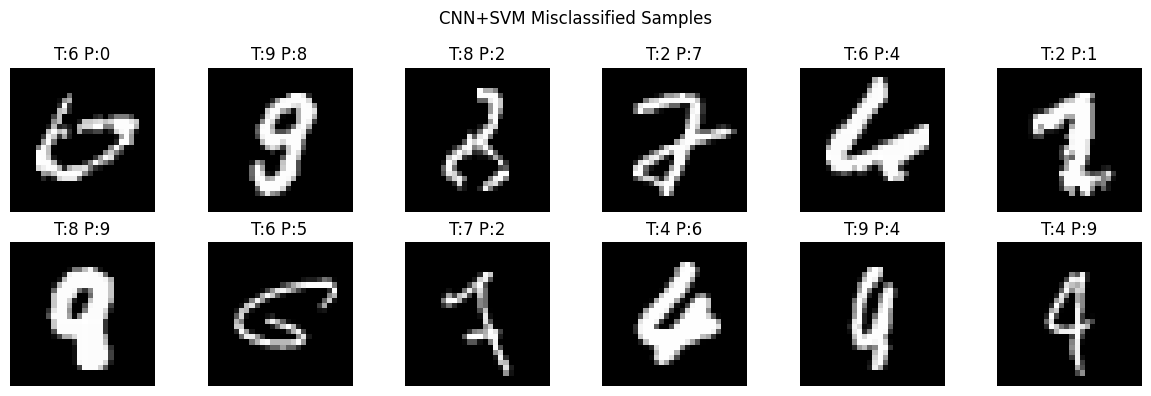

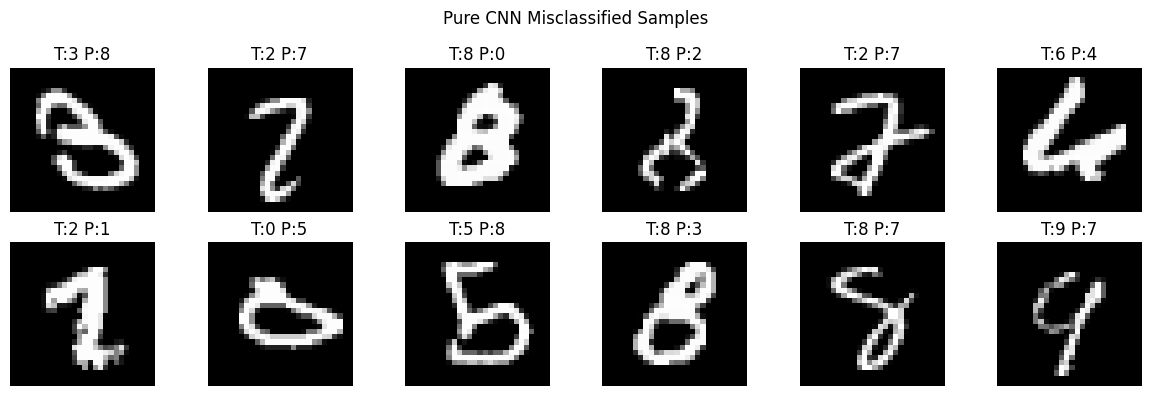

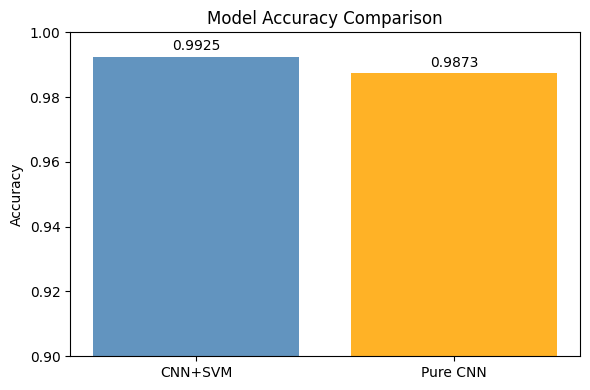

In [ ]:
# Imports for evaluation plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Ensure we have predictions from earlier cells:
# - y_pred_svm (from SVM on PCA features)
# - y_pred_cnn (from pure CNN)
# - y_pred_svm_only (from SVM-only pipeline)
# - y_test (ground truth)

# Confusion matrices
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_svm_only = confusion_matrix(y_test, y_pred_svm_only)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN+SVM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Confusion Matrix - Pure CNN')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(cm_svm_only, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Confusion Matrix - SVM-only')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

# Per-class metrics
prec_svm, rec_svm, f1_svm, sup_svm = precision_recall_fscore_support(y_test, y_pred_svm, labels=list(range(10)))
prec_cnn, rec_cnn, f1_cnn, sup_cnn = precision_recall_fscore_support(y_test, y_pred_cnn, labels=list(range(10)))
prec_svm_only, rec_svm_only, f1_svm_only, sup_svm_only = precision_recall_fscore_support(y_test, y_pred_svm_only, labels=list(range(10)))

x = np.arange(10)
width = 0.27

plt.figure(figsize=(16, 5))
plt.bar(x - width, f1_svm, width, label='CNN+SVM F1', alpha=0.9)
plt.bar(x, f1_cnn, width, label='CNN F1', alpha=0.7)
plt.bar(x + width, f1_svm_only, width, label='SVM-only F1', alpha=0.7)
plt.xticks(x, list(range(10)))
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Misclassified samples (show a few for each model)
mis_svm = np.where(y_pred_svm != y_test)[0]
mis_cnn = np.where(y_pred_cnn != y_test)[0]
mis_svm_only = np.where(y_pred_svm_only != y_test)[0]

num_show = 12

if mis_svm.size > 0:
    cols = 6
    rows = int(np.ceil(min(num_show, mis_svm.size)/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i, idx in enumerate(mis_svm[:num_show]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"T:{y_test[idx]} P:{y_pred_svm[idx]}")
        plt.axis('off')
    plt.suptitle('CNN+SVM Misclassified Samples')
    plt.tight_layout()
    plt.show()

if mis_cnn.size > 0:
    cols = 6
    rows = int(np.ceil(min(num_show, mis_cnn.size)/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i, idx in enumerate(mis_cnn[:num_show]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"T:{y_test[idx]} P:{y_pred_cnn[idx]}")
        plt.axis('off')
    plt.suptitle('Pure CNN Misclassified Samples')
    plt.tight_layout()
    plt.show()

if mis_svm_only.size > 0:
    cols = 6
    rows = int(np.ceil(min(num_show, mis_svm_only.size)/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i, idx in enumerate(mis_svm_only[:num_show]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"T:{y_test[idx]} P:{y_pred_svm_only[idx]}")
        plt.axis('off')
    plt.suptitle('SVM-only Misclassified Samples')
    plt.tight_layout()
    plt.show()

# Accuracy comparison bar chart
svm_hybrid_accuracy = accuracy_score(y_test, y_pred_svm)
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
svm_only_accuracy = accuracy_score(y_test, y_pred_svm_only)

plt.figure(figsize=(7, 4))
labels = ['CNN+SVM', 'Pure CNN', 'SVM-only']
values = [svm_hybrid_accuracy, cnn_accuracy, svm_only_accuracy]
bars = plt.bar(labels, values, color=['steelblue', 'orange', 'seagreen'], alpha=0.85)
plt.ylim(0.9, 1.0)
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.002, f"{v:.4f}", ha='center')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()
